In [1]:
import glob
import time
import numpy as np
from car_detection import *
from functools import reduce
import matplotlib.pyplot as plt
from image_helpers import *
from moviepy.editor import VideoFileClip
from data_loading import load_vehicle_lists
from scipy.ndimage.measurements import label

%matplotlib inline

In [2]:
X_train_list, y_train, X_test_list, y_test = load_vehicle_lists("data/", test_size=0.15)

Non-car images (train/test): 7622 / 1346
Car images (train/test): 7471 / 1321
Total train/test split: 14942 / 2642


In [3]:
# Parameters
detector = CarDetector(color_space='YCrCb', spatial_size=(16, 16), hist_bins=32,
                       orient=16, pix_per_cell=16, cell_per_block=2, hog_channel='ALL',
                       spatial_feat=True, hist_feat=True, hog_feat=True, fast=True)

detector.train_model(X_train_list, y_train, X_test_list, y_test)

70.85 seconds to extract the features of all images...
Feature vector length: 2592
4.9 seconds to train SVC...
Test Accuracy of SVC =  0.9905
My SVC predicts:  [0 0 0 0 1 1 0 0 0 0]
For these 10 labels:  (0, 0, 0, 0, 1, 1, 0, 0, 0, 0)
0.00491 seconds to predict 10 labels with SVC


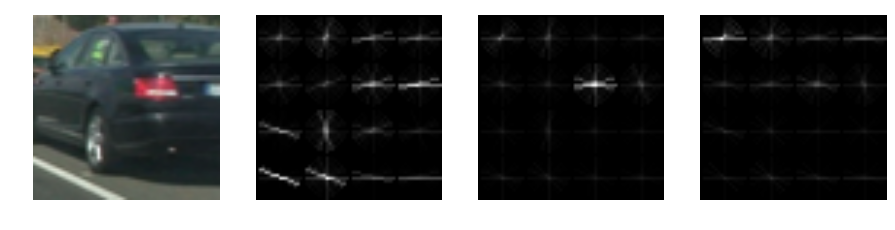

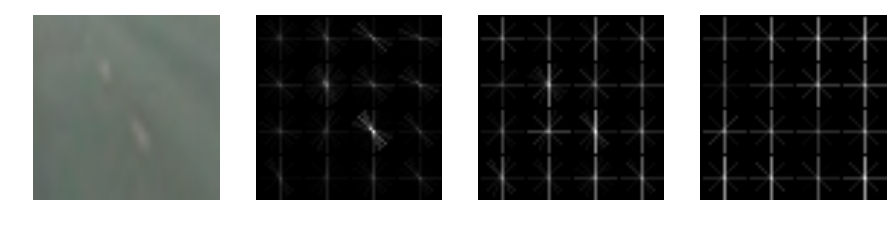

In [6]:
image = img_load('data/vehicles/GTI_Right/image0003.png')
ycrcb = img_convert(image, 'YCrCb')
_, hog_img0 = get_hog_features(ycrcb[:,:,0], 16, 16, 2, vis=True, feature_vec=False, fast=False)
_, hog_img1 = get_hog_features(ycrcb[:,:,1], 16, 16, 2, vis=True, feature_vec=False, fast=False)
_, hog_img2 = get_hog_features(ycrcb[:,:,2], 16, 16, 2, vis=True, feature_vec=False, fast=False)

plt.figure(figsize=(11, 8))
plt.subplot(141)
plt.imshow(image)
plt.axis('off')
plt.subplot(142)
plt.imshow(hog_img0, cmap='gray')
plt.axis('off')
plt.subplot(143)
plt.imshow(hog_img1, cmap='gray')
plt.axis('off')
plt.subplot(144)
plt.imshow(hog_img2, cmap='gray')
plt.axis('off')
plt.show()

image = img_load('data/non-vehicles/GTI/image3.png')
ycrcb = img_convert(image, 'YCrCb')
_, hog_img0 = get_hog_features(ycrcb[:,:,0], 16, 16, 2, vis=True, feature_vec=False, fast=False)
_, hog_img1 = get_hog_features(ycrcb[:,:,1], 16, 16, 2, vis=True, feature_vec=False, fast=False)
_, hog_img2 = get_hog_features(ycrcb[:,:,2], 16, 16, 2, vis=True, feature_vec=False, fast=False)

plt.figure(figsize=(11, 8))
plt.subplot(141)
plt.imshow(image)
plt.axis('off')
plt.subplot(142)
plt.imshow(hog_img0, cmap='gray')
plt.axis('off')
plt.subplot(143)
plt.imshow(hog_img1, cmap='gray')
plt.axis('off')
plt.subplot(144)
plt.imshow(hog_img2, cmap='gray')
plt.axis('off')
plt.show()

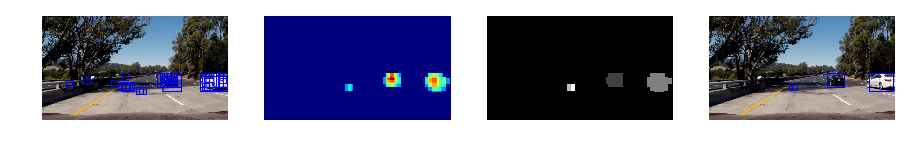

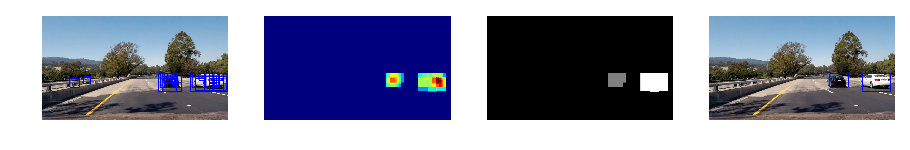

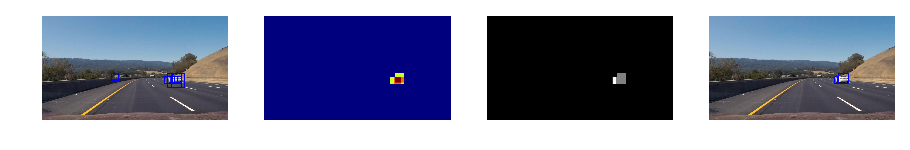

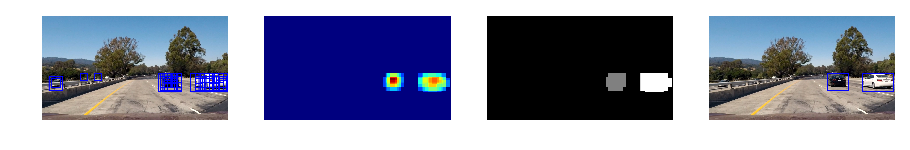

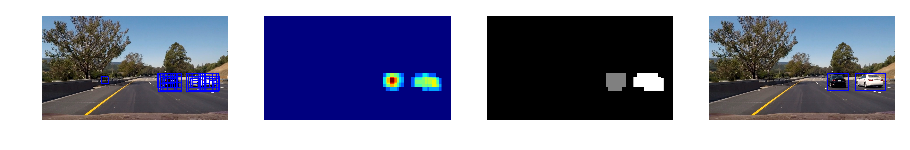

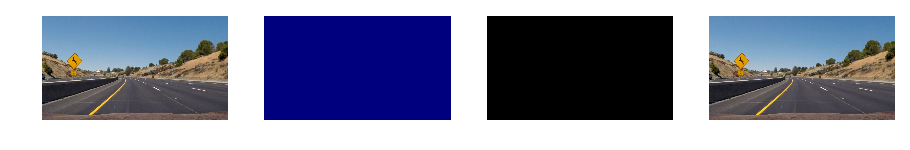

In [7]:

image_list = glob.glob("test_images/test*.jpg")

# Window size and sliding step in number of hog cells (>=8 means no overlapping)
win_sizes = [(48, 2, 560),
             (64, 2, 576),
             (96, 1, 608),
             (128, 1, 624)]

for fname in image_list:
    image = img_load(fname)
    bboxes = detector.detect_cars(image, win_sizes, ytop=400)

    # Draw the bounding boxes
    window_img = image.copy()
    window_img = draw_boxes(window_img, bboxes, color=(0, 0, 255), thick=6)
    # Add bounding boxes to the heat map
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, bboxes)        
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    bboxes = labeled_bboxes(labels)
    draw_img = draw_boxes(image, bboxes, color=(0, 0, 255), thick=6)

    plt.figure(figsize=(11, 8))
    plt.subplot(141)
    plt.imshow(window_img)
    plt.axis('off')
    plt.subplot(142)
    plt.imshow(heatmap)
    plt.axis('off')
    plt.subplot(143)
    plt.imshow(labels[0], cmap='gray')
    plt.axis('off')
    plt.subplot(144)
    plt.imshow(draw_img)
    plt.axis('off')
    plt.show()

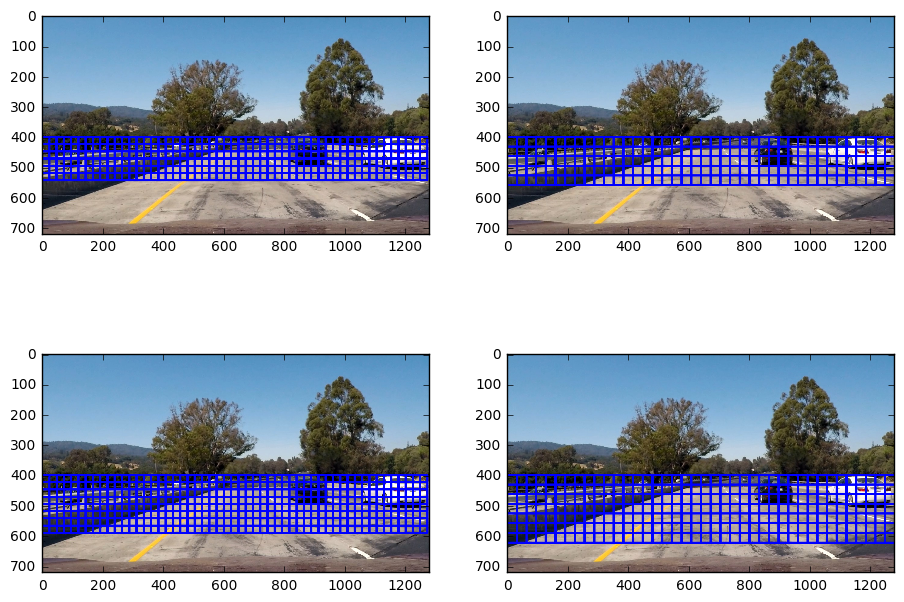

In [10]:
image = img_load("test_images/test1.jpg")
draws = []
for win_size, blocks_per_step, ybottom in win_sizes:
    # Calculate the hog cell size in a non-scaled image
    # There are (64 / pix_per_cell) number of cells in a 64px image,
    # So before resizing the window, a hog cell will have hog_cell_size pixels
    hog_cell_size = (16 * win_size) // 64
    step = blocks_per_step * hog_cell_size
    # Calculate sliding windows with a step, multiple of the hog cell size
    windows = detector.slide_window(x_start_stop=(0, 1280), y_start_stop=(400, ybottom),
                                xy_window=(win_size, win_size), xy_step=(step, step))
    
    draw_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)
    draws.append(draw_img)


plt.figure(figsize=(11, 8))
plt.subplot(221)
plt.imshow(draws[0])
plt.subplot(222)
plt.imshow(draws[1])
plt.subplot(223)
plt.imshow(draws[2])
plt.subplot(224)
plt.imshow(draws[3])
plt.show()

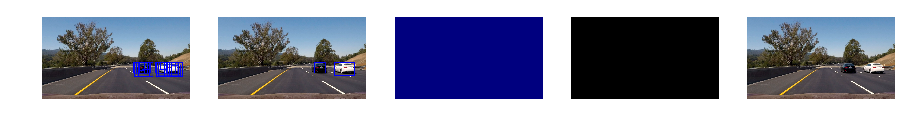

[MoviePy] >>>> Building video test_video_detected.mp4
[MoviePy] Writing video test_video_detected.mp4


  0%|          | 0/39 [00:00<?, ?it/s]

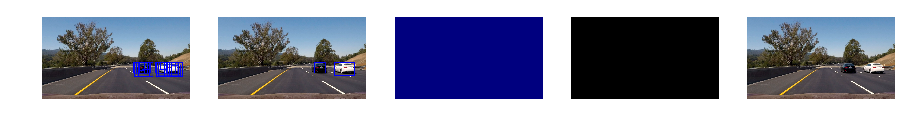

  3%|▎         | 1/39 [00:07<05:02,  7.95s/it]

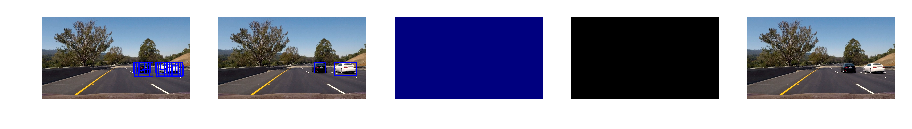

  5%|▌         | 2/39 [00:15<04:45,  7.71s/it]

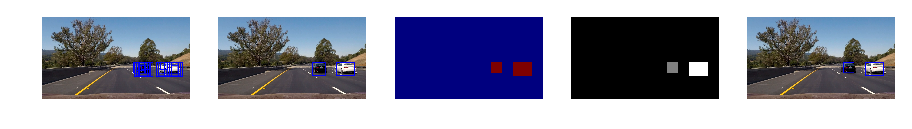

  8%|▊         | 3/39 [00:22<04:31,  7.55s/it]

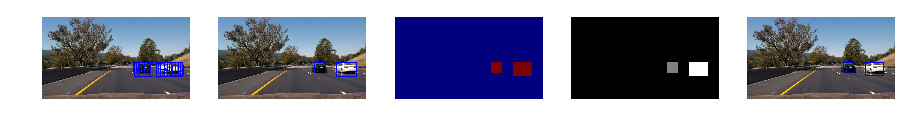

 10%|█         | 4/39 [00:29<04:17,  7.35s/it]

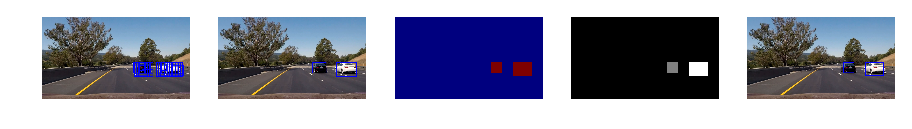

 13%|█▎        | 5/39 [00:33<03:43,  6.58s/it]

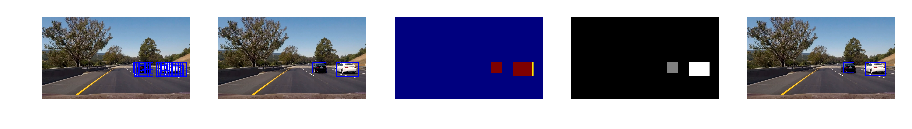

 15%|█▌        | 6/39 [00:41<03:49,  6.97s/it]

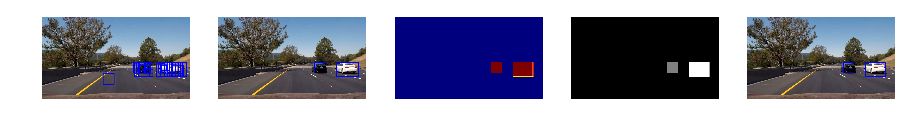

 18%|█▊        | 7/39 [00:49<03:48,  7.15s/it]

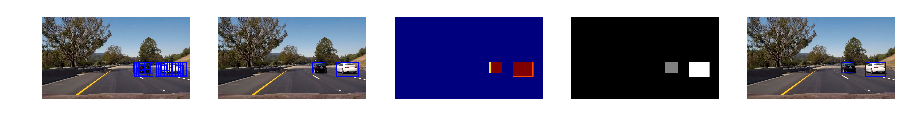

 21%|██        | 8/39 [00:56<03:39,  7.07s/it]

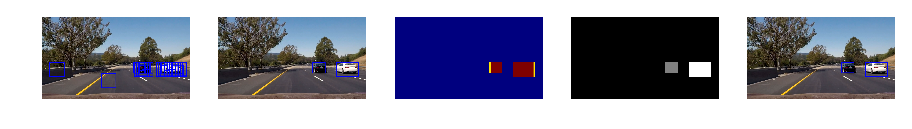

 23%|██▎       | 9/39 [01:03<03:30,  7.01s/it]

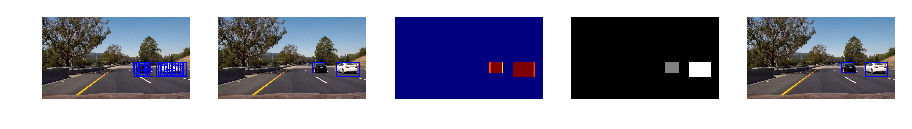

 26%|██▌       | 10/39 [01:10<03:25,  7.08s/it]

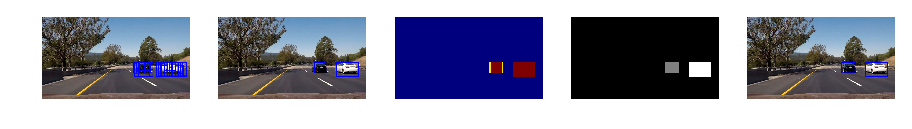

 28%|██▊       | 11/39 [01:16<03:13,  6.92s/it]

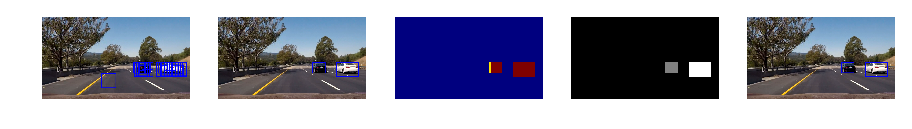

 31%|███       | 12/39 [01:22<02:59,  6.66s/it]

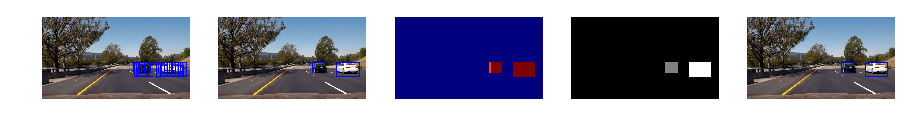

 33%|███▎      | 13/39 [01:29<02:52,  6.63s/it]

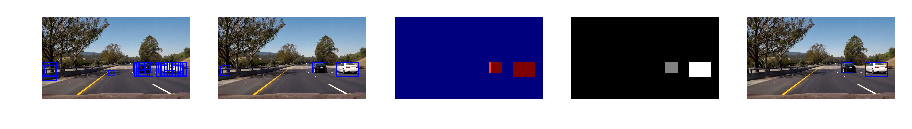

 36%|███▌      | 14/39 [01:38<03:06,  7.45s/it]

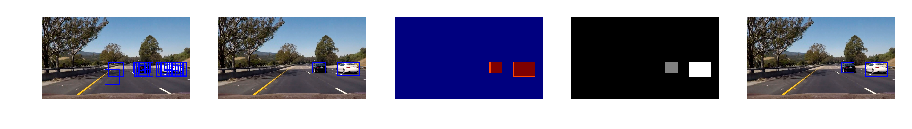

 38%|███▊      | 15/39 [01:44<02:48,  7.02s/it]

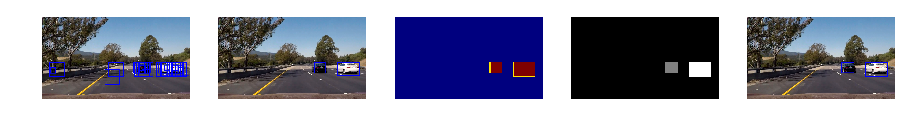

 41%|████      | 16/39 [01:52<02:44,  7.16s/it]

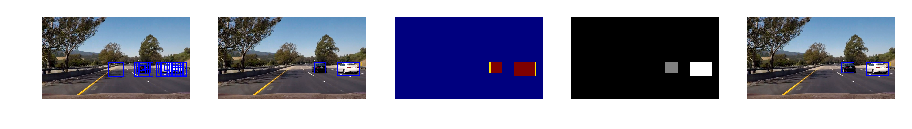

 44%|████▎     | 17/39 [01:59<02:36,  7.10s/it]

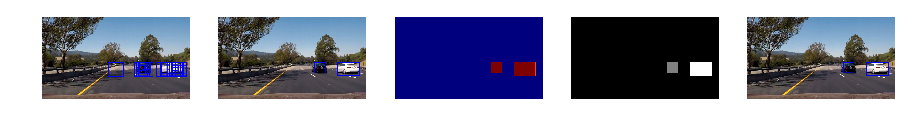

 46%|████▌     | 18/39 [02:07<02:34,  7.35s/it]

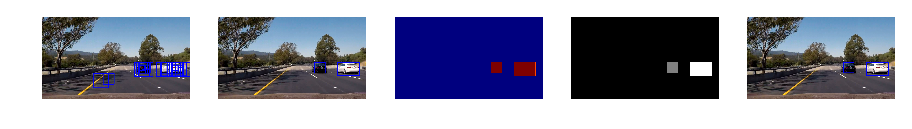

 49%|████▊     | 19/39 [02:15<02:29,  7.47s/it]

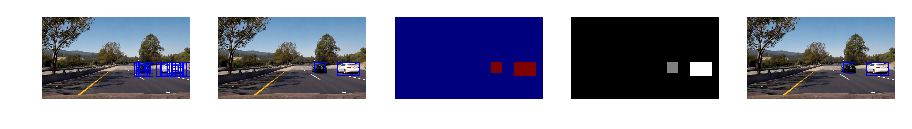

 51%|█████▏    | 20/39 [02:21<02:17,  7.25s/it]

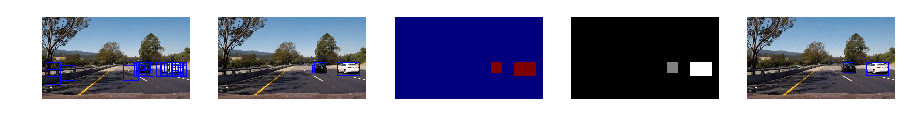

 54%|█████▍    | 21/39 [02:27<02:02,  6.81s/it]

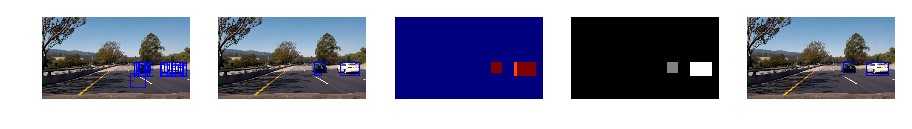

 56%|█████▋    | 22/39 [02:33<01:51,  6.56s/it]

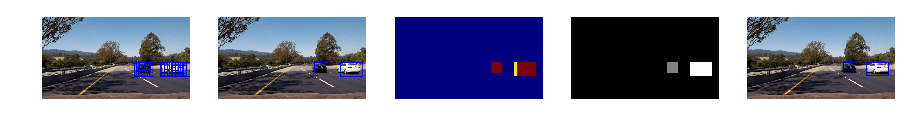

 59%|█████▉    | 23/39 [02:40<01:47,  6.73s/it]

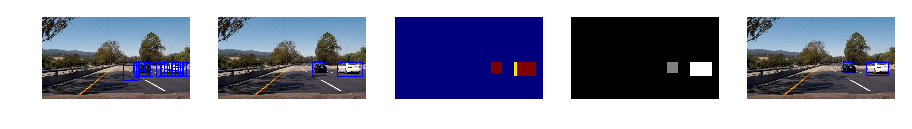

 62%|██████▏   | 24/39 [02:47<01:41,  6.77s/it]

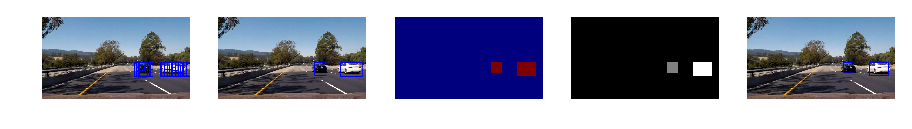

 64%|██████▍   | 25/39 [02:54<01:33,  6.68s/it]

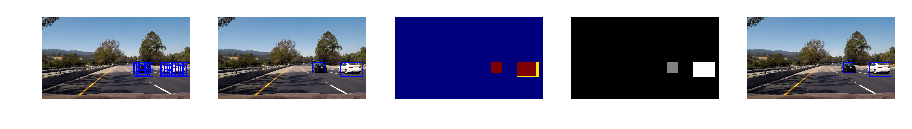

 67%|██████▋   | 26/39 [02:59<01:21,  6.28s/it]

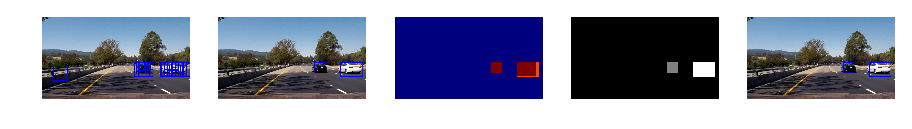

 69%|██████▉   | 27/39 [03:05<01:14,  6.21s/it]

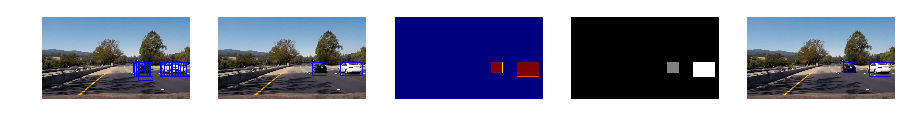

 72%|███████▏  | 28/39 [03:12<01:11,  6.51s/it]

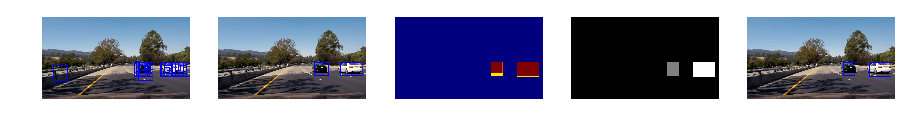

 74%|███████▍  | 29/39 [03:19<01:05,  6.58s/it]

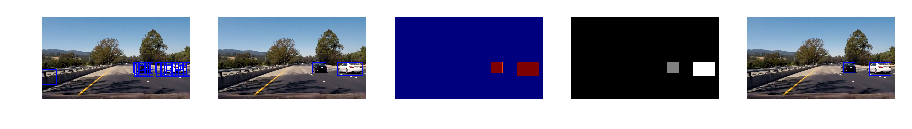

 77%|███████▋  | 30/39 [03:26<01:00,  6.72s/it]

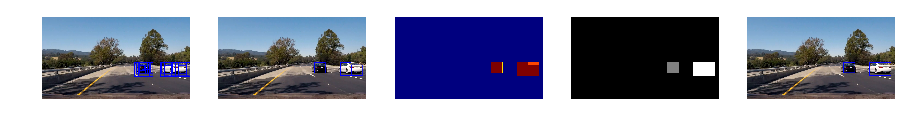

 79%|███████▉  | 31/39 [03:34<00:56,  7.08s/it]

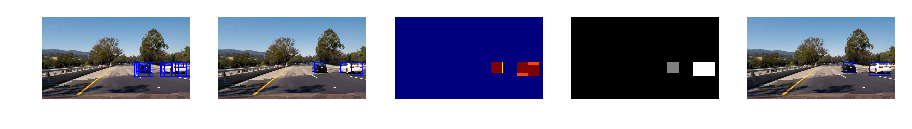

 82%|████████▏ | 32/39 [03:42<00:51,  7.33s/it]

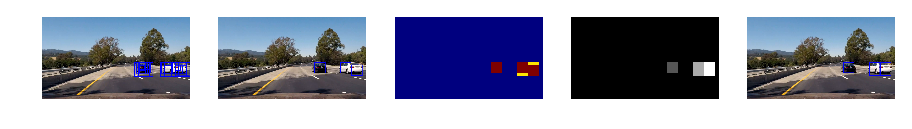

 85%|████████▍ | 33/39 [03:50<00:45,  7.63s/it]

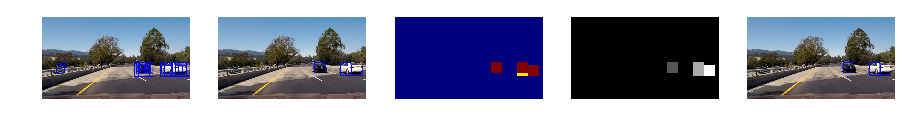

 87%|████████▋ | 34/39 [03:57<00:37,  7.51s/it]

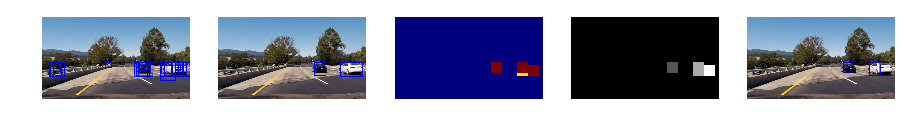

 90%|████████▉ | 35/39 [04:03<00:28,  7.01s/it]

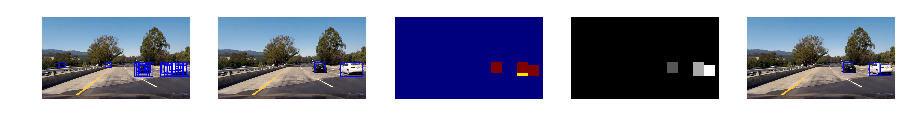

 92%|█████████▏| 36/39 [04:10<00:20,  6.99s/it]

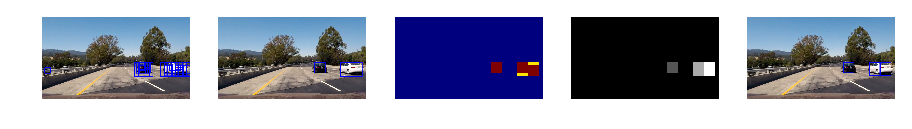

 95%|█████████▍| 37/39 [04:17<00:13,  6.87s/it]

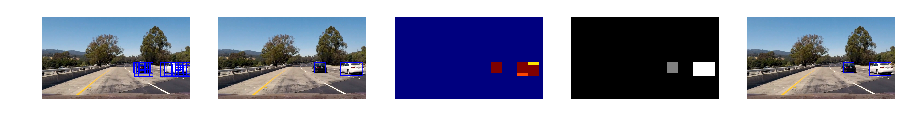

 97%|█████████▋| 38/39 [04:23<00:06,  6.78s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_detected.mp4 



In [11]:
win_sizes = [(48, 2, 560),
             (64, 2, 576),
             (96, 1, 608),
             (128, 1, 624)]
heatmap_history = []
max_history = 5
history_thresh = 3
frame_thresh = 3
index = 0

def windows_to_cars(image, bboxes, thresh):
    global index
    # Empty heat image
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add bounding boxes from the current frame
    heat = add_heat(heat, bboxes)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, thresh)
    heatmap = np.clip(heat, 0, 255)
    plt.subplot(153)
    plt.imshow(heatmap)
    plt.axis('off')
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    plt.subplot(154)
    plt.imshow(labels[0], cmap='gray')
    plt.axis('off')
    bboxes = labeled_bboxes(labels)
    return bboxes

def process_image(image):
    global heatmap_history
    global max_history
    global frame_thresh
    global history_thresh
    global index
    plt.figure(figsize=(11, 8))
    bboxes = detector.detect_cars(image, win_sizes, ytop=400)
    draw_img = draw_boxes(image, bboxes, color=(0, 0, 255), thick=6)
    plt.subplot(151)
    plt.imshow(draw_img)
    plt.axis('off')
    # Get boxes for the current frame
    current_bboxes = windows_to_cars(image, bboxes, frame_thresh)
    draw_img = draw_boxes(image, current_bboxes, color=(0, 0, 255), thick=6)
    plt.subplot(152)
    plt.imshow(draw_img)
    plt.axis('off')
    # Get and update history
    hist = reduce((lambda x, y: x + y), heatmap_history, [])
    heatmap_history = heatmap_history[-(max_history-1):] + [current_bboxes]
    # Generate final bboxes
    final_bboxes = windows_to_cars(image, current_bboxes + hist, history_thresh)
    # Draw final bboxes
    draw_img = draw_boxes(image, final_bboxes, color=(0, 0, 255), thick=6)
    plt.subplot(155)
    plt.imshow(draw_img)
    plt.axis('off')
    index = index + 1
    plt.show()
    return draw_img

input_video = 'test_video.mp4'
output_video = 'test_video_detected.mp4'

clip1 = VideoFileClip(input_video)
video_clip = clip1.fl_image(process_image)
video_clip.write_videofile(output_video, audio=False)